In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from polymarket_events import Polymarket_events

In [4]:
leagues = ['NBA', 'NFL', 'NHL', 'NCAA']

In [5]:
def read_results(league):
    dir = f'database/{league}/results'
    list_dir = os.listdir(dir)
    pd_list = []
    for file in list_dir:
        file_dir = os.path.join(dir, file)
        df = pd.read_csv(file_dir)
        pd_list.append(df)
    results = pd.concat(pd_list)
    results = results.drop_duplicates()
    results['winner'] = np.where(
        results['home_team_score'] > results['away_team_score'], results['home_team'],
        np.where(results['home_team_score'] < results['away_team_score'], results['away_team'], 'Draw')
)
    return results.reset_index(drop=True)

def read_signals(league):
    dir = f'database/{league}/signals'
    list_dir = os.listdir(dir)
    pd_list = []
    for file in list_dir:
        file_dir = os.path.join(dir, file)
        df = pd.read_csv(file_dir)
        pd_list.append(df)
    signals = pd.concat(pd_list)
    signals = signals.reset_index().rename(columns={'level_0': 'match',
                                                'level_1': 'commence_time',
                                                'level_2': 'team'})
    return signals

In [6]:
signals = pd.concat([read_signals(league) for league in leagues]).reset_index(drop=True)
results = pd.concat([read_results(league) for league in leagues]).reset_index(drop=True)

C:\Users\1\AppData\Local\Temp\ipykernel_4292\905741052.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  signals = pd.concat(pd_list)
C:\Users\1\AppData\Local\Temp\ipykernel_4292\905741052.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  signals = pd.concat(pd_list)
C:\Users\1\AppData\Local\Temp\ipykernel_4292\905741052.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA 

In [7]:
winner_df = results[['match_id', 'winner']]
signals = signals.drop_duplicates(subset=['match_id', 'team'], keep='last')
signals = signals.dropna()
condition_1 = signals.duplicated(subset=['commence_time', 'team'], keep='last') & (signals['count'] < 8)
condition_2 = signals.duplicated(subset=['commence_time', 'team'], keep='first') & (signals['count'] < 8)
signals = signals[~condition_1]
signals = signals[~condition_2]
signals = signals.reset_index(drop=True)
merdged_df = signals.merge(winner_df, on='match_id')
merdged_df = merdged_df.drop_duplicates(subset=['match_id', 'team'], keep='last')

C:\Users\1\AppData\Local\Temp\ipykernel_4292\1668678232.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  signals = signals[~condition_2]


In [12]:
DEP = 200
betting_table = merdged_df[merdged_df['best_bid_kelly'] > 0]
betting_table = betting_table[betting_table['best_bid'] < betting_table['min']]
betting_table['bet'] = betting_table['best_bid_kelly'] * DEP
betting_table['potential_profit'] = betting_table['bet'] * (1/betting_table['best_bid']) - betting_table['bet']
betting_table['outcome'] = np.where(betting_table['team'] == betting_table['winner'], betting_table['potential_profit'], -betting_table['bet'])
betting_table = betting_table.sort_values(by='commence_time').reset_index(drop=True)

C:\Users\1\AppData\Local\Temp\ipykernel_4292\1904606596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_table['bet'] = betting_table['best_bid_kelly'] * DEP
C:\Users\1\AppData\Local\Temp\ipykernel_4292\1904606596.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_table['potential_profit'] = betting_table['bet'] * (1/betting_table['best_bid']) - betting_table['bet']
C:\Users\1\AppData\Local\Temp\ipykernel_4292\1904606596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [13]:
merdged_df

,match,commence_time,team,league,best_bid,best_ask,mean,min,max,std,best_bid_kelly,best_ask_kelly,match_id,count,winner
0,Hawks vs. Bucks,2024-12-14,Atlanta Hawks,NBA,0.37,0.38,0.384845,0.377451,0.393484,0.004998,0.023564,0.007815,9c0cdf4d91abf7e718d57cb1565a7079,9.0,Milwaukee Bucks
1,Hawks vs. Bucks,2024-12-14,Milwaukee Bucks,NBA,0.62,0.63,0.615155,0.606516,0.622549,0.004998,-0.012751,-0.040123,9c0cdf4d91abf7e718d57cb1565a7079,9.0,Milwaukee Bucks
2,Rockets vs. Thunder,2024-12-15,Houston Rockets,NBA,0.30,0.31,0.322538,0.314607,0.334895,0.006598,0.032197,0.018171,5a58a058b265aa10346a63c741bfdc43,9.0,Oklahoma City Thunder
3,Rockets vs. Thunder,2024-12-15,Oklahoma City Thunder,NBA,0.69,0.70,0.677462,0.665105,0.685393,0.006598,-0.040446,-0.075127,5a58a058b265aa10346a63c741bfdc43,9.0,Oklahoma City Thunder
4,Celtics vs. Wizards,2024-12-15,Boston Celtics,NBA,0.91,0.92,0.885778,0.872365,0.904159,0.012401,-0.269128,-0.427769,d06ca60172ba8aa0a163912aef82c90c,8.0,Boston Celtics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Utah vs. Sharks,2024-12-15,San Jose Sharks,NHL,0.36,0.38,0.378473,0.371703,0.385749,0.004895,0.028865,-0.002462,e0705d2dbaccfee831399983caa4e97f,9.0,Utah Hockey Club
82,Navy vs. Army,2024-12-14,Navy Midshipmen,NCAA,0.29,0.30,0.315054,0.305122,0.341176,0.011410,0.035287,0.021506,2cfb2f7d9fabef29d5d3e119f9da1c48,9.0,Navy Midshipmen
83,Navy vs. Army,2024-12-14,Army Black Knights,NCAA,0.70,0.71,0.684946,0.658824,0.694878,0.011410,-0.050180,-0.086393,2cfb2f7d9fabef29d5d3e119f9da1c48,9.0,Navy Midshipmen
84,South Alabama vs. Western Michigan,2024-12-15,South Alabama Jaguars,NCAA,0.73,0.74,0.717994,0.691964,0.724638,0.011174,-0.044465,-0.084637,c63fab4c9cb95b883f9349d582bb34c0,8.0,South Alabama Jaguars


<Axes: >

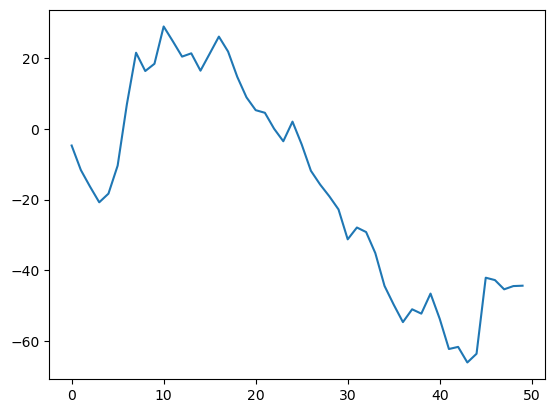

In [14]:
betting_table.reset_index()['outcome'].cumsum().plot()